# Préparation de l'environnement

In [ ]:
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 549.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 7.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 53.5 MB/s eta 0:00:00
IN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Mask_RCNN/images

/content/drive/MyDrive/Mask_RCNN/images


# Chargement du modèle pré-entrainé

In [ ]:
import torchvision.models.detection as detection
import torchvision.transforms as T
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Charger un modèle Mask R-CNN pré-entraîné
model = detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

# Fonction pour l'attaque adversariale

L'attaque **FGSM** (Fast Gradient Sign Method) consiste à perturber une image d'entrée $( x ) $en fonction du gradient de la fonction de perte $( J(\theta, x, y) )$ par rapport à l'image, dans le but de tromper le modèle de manière subtile mais efficace. La perturbation est calculée à partir du signe du gradient, ce qui permet d'ajouter un bruit à l'image dans la direction qui augmente la perte.

La formule mathématique pour calculer la perturbation est la suivante :$[
\delta = \epsilon \cdot \text{sign}(\nabla_x J(\theta, x, y))
]$
où :
- $( \delta ) $est la perturbation appliquée à l'image,
- $( \epsilon )$ est un paramètre de contrôle qui détermine la magnitude de la perturbation,
- $( \nabla_x J(\theta, x, y) )$ est le gradient de la fonction de perte $( J )$ par rapport à l'entrée $( x )$ et aux paramètres $( \theta )$ du modèle,
- $( \text{sign} )$ représente le signe du gradient pour chaque pixel de l'image.

La nouvelle image attaquée est obtenue en ajoutant la perturbation à l'image originale :
$[
x_{adv} = x + \delta
]$

L'attaque FGSM est simple et rapide, mais elle est souvent moins robuste contre les modèles adversarialement entraînés comparée à d'autres attaques comme PGD.


In [ ]:
def fgsm_attack(model, image, epsilon=0.03, threshold=0.5):
    """
    Effectuer une attaque FGSM sur un modèle Mask R-CNN.
    :param model: Le modèle Mask R-CNN
    :param image: L'image d'entrée (Tensor PyTorch)
    :param epsilon: La taille de la perturbation
    :param threshold: Le seuil pour les scores des détections
    :return: L'image adversariale
    """
    # Assurez-vous que l'image nécessite des gradients
    image = image.requires_grad_(True)

    # Passer l'image dans le modèle pour obtenir les résultats
    output = model(image)

    # Utiliser les scores de détection comme perte (maximiser le score)
    scores = output[0]['scores']

    if len(scores) == 0:
        print("Aucune détection détectée, arrêt de l'attaque.")
        return image

    # Calculer la perte en maximisant les scores de détection
    loss = -scores.max()  # Maximiser le score de la meilleure détection

    # Calculer les gradients de la perte par rapport à l'image
    loss.backward()

    # Récupérer les gradients de l'image
    gradient = image.grad.data

    # Créer la perturbation (FGSM)
    perturbation = epsilon * gradient.sign()

    # Créer l'image adversariale
    adv_image = image + perturbation

    # Contrôler que l'image reste dans la plage [0, 1]
    adv_image = torch.clamp(adv_image, 0, 1)

    return adv_image

# Evaluation des performances avec les scores moyens

In [ ]:
def evaluate_performance(output_original, output_adversarial, iou_threshold=0.5):
    """
    Compare les performances du modèle sur les images originale et adversariale.

    :param output_original: Résultats du modèle sur l'image originale.
    :param output_adversarial: Résultats du modèle sur l'image adversariale.
    :param iou_threshold: Seuil pour considérer une correspondance entre deux boîtes.
    :return: Résumé des différences.
    """
    from torchvision.ops import box_iou

    # Récupérer les informations
    labels_original = output_original['labels'].cpu().numpy()
    labels_adversarial = output_adversarial['labels'].cpu().numpy()
    scores_original = output_original['scores'].cpu().numpy()
    scores_adversarial = output_adversarial['scores'].cpu().numpy()
    boxes_original = output_original['boxes'].cpu()
    boxes_adversarial = output_adversarial['boxes'].cpu()

    # Nombre de détections
    num_detections_original = len(labels_original)
    num_detections_adversarial = len(labels_adversarial)

    # IoU entre les boîtes
    iou_matrix = box_iou(boxes_original, boxes_adversarial)
    matched_boxes = (iou_matrix > iou_threshold).sum().item()

    # Différence dans les scores moyens
    avg_score_original = scores_original.mean() if num_detections_original > 0 else 0
    avg_score_adversarial = scores_adversarial.mean() if num_detections_adversarial > 0 else 0

    # Résumé des différences
    result = {
        "num_detections_original": num_detections_original,
        "num_detections_adversarial": num_detections_adversarial,
        "matched_boxes": matched_boxes,
        "avg_score_original": avg_score_original,
        "avg_score_adversarial": avg_score_adversarial,
        "labels_original": labels_original.tolist(),
        "labels_adversarial": labels_adversarial.tolist()
    }

    return result

In [ ]:
def process_images_in_folder(folder_path, model, epsilon=0.03, iou_threshold=0.5):
    """
    Applique une attaque FGSM sur toutes les images d'un dossier et évalue les différences de performance.

    :param folder_path: Chemin vers le dossier contenant les images
    :param model: Modèle Mask R-CNN pré-entraîné
    :param epsilon: Taille de la perturbation pour l'attaque FGSM
    :param iou_threshold: Seuil d'IoU pour considérer une correspondance
    :return: Moyenne des différences de performance
    """
    from PIL import Image
    import torchvision.transforms as T
    import torch

    # Transformation des images
    transform = T.Compose([T.ToTensor()])

    # Stocker les résultats
    results = []

    # Parcourir toutes les images du dossier
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        # Vérifier si le fichier est une image
        if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        try:
            # Charger et transformer l'image
            image = Image.open(image_path).convert("RGB")
            input_tensor = transform(image).unsqueeze(0)  # Ajouter une dimension batch

            # Appliquer l'attaque FGSM
            adv_image = fgsm_attack(model, input_tensor, epsilon=epsilon)

            # Passer l'image originale et l'image adversariale dans le modèle
            with torch.no_grad():
                output_original = model(input_tensor)[0]
                output_adversarial = model(adv_image)[0]

            # Évaluer la différence de performance
            result = evaluate_performance(output_original, output_adversarial, iou_threshold=iou_threshold)
            results.append(result)

            print(f"Traitement terminé pour : {image_name}")

        except Exception as e:
            print(f"Erreur pour l'image {image_name}: {e}")

    # Calculer les moyennes des métriques
    avg_num_detections_original = sum(r["num_detections_original"] for r in results) / len(results)
    avg_num_detections_adversarial = sum(r["num_detections_adversarial"] for r in results) / len(results)
    avg_matched_boxes = sum(r["matched_boxes"] for r in results) / len(results)
    avg_score_original = sum(r["avg_score_original"] for r in results) / len(results)
    avg_score_adversarial = sum(r["avg_score_adversarial"] for r in results) / len(results)

    return {
        "avg_num_detections_original": avg_num_detections_original,
        "avg_num_detections_adversarial": avg_num_detections_adversarial,
        "avg_matched_boxes": avg_matched_boxes,
        "avg_score_original": avg_score_original,
        "avg_score_adversarial": avg_score_adversarial
    }

In [ ]:
import os
# Appliquer l'attaque sur toutes les images du dossier
final_results = process_images_in_folder(".", model, epsilon=0.03)

# Afficher les moyennes
print("Résultats moyens des différences de performance epsilon=0.03 :")
for key, value in final_results.items():
    print(f"{key}: {value}")

Traitement terminé pour : 6821351586_59aa0dc110_z.jpg
Traitement terminé pour : 7581246086_cf7bbb7255_z.jpg
Traitement terminé pour : 8239308689_efa6c11b08_z.jpg
Traitement terminé pour : 6584515005_fce9cec486_z.jpg
Traitement terminé pour : 4782628554_668bc31826_z.jpg
Traitement terminé pour : 25691390_f9944f61b5_z.jpg
Traitement terminé pour : 12283150_12d37e6389_z.jpg
Traitement terminé pour : 4410436637_7b0ca36ee7_z.jpg
Traitement terminé pour : 3132016470_c27baa00e8_z.jpg
Traitement terminé pour : 262985539_1709e54576_z.jpg
Traitement terminé pour : 3627527276_6fe8cd9bfe_z.jpg
Traitement terminé pour : 1045023827_4ec3e8ba5c_z.jpg
Traitement terminé pour : 2502287818_41e4b0c4fb_z.jpg
Traitement terminé pour : 7933423348_c30bd9bd4e_z.jpg
Traitement terminé pour : 8734543718_37f6b8bd45_z.jpg
Traitement terminé pour : 3878153025_8fde829928_z.jpg
Traitement terminé pour : 2516944023_d00345997d_z.jpg
Traitement terminé pour : 9118579087_f9ffa19e63_z.jpg
Traitement terminé pour : 2383514

# Evaluation des performances avec les métriques de l'article

In [ ]:
import numpy as np
import torch
from torchvision.ops import box_iou

def calculate_ap(true_boxes, pred_boxes, pred_scores, iou_thresholds):
    """
    Calcule Average Precision (AP) pour une série de seuils IoU.
    """
    ap_values = []
    for iou_thresh in iou_thresholds:
        matched = 0
        used = set()

        # Trier les prédictions par score décroissant
        sorted_indices = np.argsort(-pred_scores)
        pred_boxes = pred_boxes[sorted_indices]

        # Correspondance des boîtes
        for pred_box in pred_boxes:
            for i, true_box in enumerate(true_boxes):
                if i in used:
                    continue
                # Calcul de l'IoU entre les boîtes prédites et réelles
                iou = box_iou(pred_box.unsqueeze(0), true_box.unsqueeze(0)).item()
                if iou >= iou_thresh:
                    matched += 1
                    used.add(i)
                    break

        precision = matched / len(pred_boxes) if len(pred_boxes) > 0 else 0
        ap_values.append(precision)

    return np.mean(ap_values) if ap_values else 0


In [ ]:
def ap_by_scale(true_boxes, pred_boxes, pred_scores, scale, iou_thresholds):
    """
    Calcule AP pour différentes tailles de boîtes (small, medium, large).
    """
    small_thresh = 32**2  # Seuil pour les petites boîtes
    medium_thresh = 96**2  # Seuil pour les boîtes moyennes

    # Calculer l'aire d'une boîte : (x_max - x_min) * (y_max - y_min)
    def box_area(box):
        # box est un tensor PyTorch de forme [xmin, ymin, xmax, ymax]
        x_min, y_min, x_max, y_max = box[0], box[1], box[2], box[3]
        return (x_max - x_min) * (y_max - y_min)

    if scale == "small":
        filtered_boxes = [box for box in true_boxes if box_area(box) <= small_thresh]
    elif scale == "medium":
        filtered_boxes = [box for box in true_boxes if small_thresh < box_area(box) <= medium_thresh]
    else:
        filtered_boxes = [box for box in true_boxes if box_area(box) > medium_thresh]

    # Si aucune boîte ne correspond aux critères, retourner une valeur par défaut
    if not filtered_boxes:
        print(f"Aucune boîte ne correspond à la taille {scale}.")
        return 0  # Ou retourne un autre comportement souhaité, comme None

    # Appeler la fonction de calcul de l'AP
    return calculate_ap(filtered_boxes, pred_boxes, pred_scores, iou_thresholds)

In [ ]:
def evaluate_coco_metrics(output_original, output_adversarial, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    """
    Calcule les métriques COCO sur les sorties originales et adversariales.
    """
    results = {
        "AP_original": 0,
        "AP_adversarial": 0,
        "AP50_original": 0,
        "AP50_adversarial": 0,
        "AP75_original": 0,
        "AP75_adversarial": 0,
        "APS_original": 0,
        "APM_original": 0,
        "APL_original": 0,
        "APS_adversarial": 0,
        "APM_adversarial": 0,
        "APL_adversarial": 0
    }

    # Récupérer les informations
    true_boxes_original = output_original['boxes'].cpu()
    pred_boxes_original = output_original['boxes'].cpu()  # Ces boîtes doivent venir de vos prédictions
    pred_scores_original = output_original['scores'].cpu().numpy()

    true_boxes_adversarial = output_adversarial['boxes'].cpu()
    pred_boxes_adversarial = output_adversarial['boxes'].cpu()  # Ces boîtes doivent venir de vos prédictions adversariales
    pred_scores_adversarial = output_adversarial['scores'].cpu().numpy()

    # Calcule AP pour les seuils IoU
    results["AP_original"] = calculate_ap(true_boxes_original, pred_boxes_original, pred_scores_original, iou_thresholds)
    results["AP_adversarial"] = calculate_ap(true_boxes_adversarial, pred_boxes_adversarial, pred_scores_adversarial, iou_thresholds)

    # Calcule AP50 et AP75
    results["AP50_original"] = calculate_ap(true_boxes_original, pred_boxes_original, pred_scores_original, [0.5])
    results["AP50_adversarial"] = calculate_ap(true_boxes_adversarial, pred_boxes_adversarial, pred_scores_adversarial, [0.5])
    results["AP75_original"] = calculate_ap(true_boxes_original, pred_boxes_original, pred_scores_original, [0.75])
    results["AP75_adversarial"] = calculate_ap(true_boxes_adversarial, pred_boxes_adversarial, pred_scores_adversarial, [0.75])

    # Ajouter les métriques par échelle (APS, APM, APL) pour l'image originale
    results["APS_original"] = ap_by_scale(true_boxes_original, pred_boxes_original, pred_scores_original, "small", iou_thresholds)
    results["APM_original"] = ap_by_scale(true_boxes_original, pred_boxes_original, pred_scores_original, "medium", iou_thresholds)
    results["APL_original"] = ap_by_scale(true_boxes_original, pred_boxes_original, pred_scores_original, "large", iou_thresholds)
    '''
    # Ajouter les métriques par échelle (APS, APM, APL) pour l'image attaquée
    results["APS_adversarial"] = ap_by_scale(true_boxes_adversarial, pred_boxes_adversarial, pred_scores_adversarial, "small", iou_thresholds)
    results["APM_adversarial"] = ap_by_scale(true_boxes_adversarial, pred_boxes_adversarial, pred_scores_adversarial, "medium", iou_thresholds)
    results["APL_adversarial"] = ap_by_scale(true_boxes_adversarial, pred_boxes_adversarial, pred_scores_adversarial, "large", iou_thresholds)
'''
    results["APS_adversarial"] = ap_by_scale(true_boxes_original, pred_boxes_adversarial, pred_scores_adversarial, "small", iou_thresholds)
    results["APM_adversarial"] = ap_by_scale(true_boxes_original, pred_boxes_adversarial, pred_scores_adversarial, "medium", iou_thresholds)
    results["APL_adversarial"] = ap_by_scale(true_boxes_original, pred_boxes_adversarial, pred_scores_adversarial, "large", iou_thresholds)

    return results

In [ ]:
def process_images_in_folder2(folder_path, model, epsilon=0.03, iou_threshold=0.5):
    """
    Applique une attaque FGSM sur toutes les images d'un dossier et évalue les différences de performance.

    :param folder_path: Chemin vers le dossier contenant les images
    :param model: Modèle Mask R-CNN pré-entraîné
    :param epsilon: Taille de la perturbation pour l'attaque FGSM
    :param iou_threshold: Seuil d'IoU pour considérer une correspondance
    :return: Moyenne des différences de performance
    """
    # Transformation des images
    transform = T.Compose([T.ToTensor()])

    # Stocker les résultats
    results = []

    # Parcourir toutes les images du dossier
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        # Vérifier si le fichier est une image
        if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        try:
            # Charger et transformer l'image
            image = Image.open(image_path).convert("RGB")
            input_tensor = transform(image).unsqueeze(0)  # Ajouter une dimension batch

            # Appliquer l'attaque FGSM
            adv_image = fgsm_attack(model, input_tensor, epsilon=epsilon)

            # Passer l'image originale et l'image adversariale dans le modèle
            with torch.no_grad():
                output_original = model(input_tensor)[0]
                output_adversarial = model(adv_image)[0]

            # Évaluer la différence de performance
            result = evaluate_coco_metrics(output_original, output_adversarial, iou_thresholds=np.arange(0.5, 1.0, 0.05))
            results.append(result)

            print(f"Traitement terminé pour : {image_name}")

        except Exception as e:
            print(f"Erreur pour l'image {image_name}: {e}")

   # Évaluer la différence de performance pour l'image originale
            result_original = evaluate_coco_metrics(output_original, output_original, iou_thresholds=np.arange(0.5, 1.0, 0.05))
            # Évaluer la différence de performance pour l'image adversariale
            result_adversarial = evaluate_coco_metrics(output_adversarial, output_adversarial, iou_thresholds=np.arange(0.5, 1.0, 0.05))

            # Ajouter les résultats à la liste
            results.append({
                "AP_original": result_original["AP_original"],
                "AP_adversarial": result_adversarial["AP_adversarial"],
                "AP50_original": result_original["AP50_original"],
                "AP50_adversarial": result_adversarial["AP50_adversarial"],
                "AP75_original": result_original["AP75_original"],
                "AP75_adversarial": result_adversarial["AP75_adversarial"],
                "APS_original": result_original["APS_original"],
                "APM_original": result_original["APM_original"],
                "APL_original": result_original["APL_original"],
                "APS_adversarial": result_adversarial["APS_original"],  # Utiliser APS pour adversarial aussi
                "APM_adversarial": result_adversarial["APM_original"],  # Utiliser APM pour adversarial aussi
                "APL_adversarial": result_adversarial["APL_original"]  # Utiliser APL pour adversarial aussi
            })

            image_count += 1
            print(f"Traitement terminé pour : {image_name}")

        except Exception as e:
            print(f"Erreur pour l'image {image_name}: {e}")

    # Calculer les moyennes des métriques pour toutes les images traitées
    avg_AP_original = np.mean([r["AP_original"] for r in results])
    avg_AP_adversarial = np.mean([r["AP_adversarial"] for r in results])
    avg_AP50_original = np.mean([r["AP50_original"] for r in results])
    avg_AP50_adversarial = np.mean([r["AP50_adversarial"] for r in results])
    avg_AP75_original = np.mean([r["AP75_original"] for r in results])
    avg_AP75_adversarial = np.mean([r["AP75_adversarial"] for r in results])
    avg_APS_original = np.mean([r["APS_original"] for r in results])
    avg_APM_original = np.mean([r["APM_original"] for r in results])
    avg_APL_original = np.mean([r["APL_original"] for r in results])
    avg_APS_adversarial = np.mean([r["APS_adversarial"] for r in results])
    avg_APM_adversarial = np.mean([r["APM_adversarial"] for r in results])
    avg_APL_adversarial = np.mean([r["APL_adversarial"] for r in results])

    return {
        "avg_AP_original": avg_AP_original,
        "avg_AP_adversarial": avg_AP_adversarial,
        "avg_AP50_original": avg_AP50_original,
        "avg_AP50_adversarial": avg_AP50_adversarial,
        "avg_AP75_original": avg_AP75_original,
        "avg_AP75_adversarial": avg_AP75_adversarial,
        "avg_APS_original": avg_APS_original,
        "avg_APM_original": avg_APM_original,
        "avg_APL_original": avg_APL_original,
        "avg_APS_adversarial": avg_APS_adversarial,
        "avg_APM_adversarial": avg_APM_adversarial,
        "avg_APL_adversarial": avg_APL_adversarial
    }

# Test avec $ϵ= 0.03$

In [ ]:
import os
# Appliquer l'attaque sur toutes les images du dossier
final_results2 = process_images_in_folder2(".", model, epsilon=0.03)

# Afficher les moyennes
print("Résultats moyens des différences de performance epsilon = 0.03 :")
for key, value in final_results2.items():
    print(f"{key}: {value}")

Traitement terminé pour : 6821351586_59aa0dc110_z.jpg
Traitement terminé pour : 7581246086_cf7bbb7255_z.jpg
Traitement terminé pour : 8239308689_efa6c11b08_z.jpg
Traitement terminé pour : 6584515005_fce9cec486_z.jpg
Aucune boîte ne correspond à la taille large.
Aucune boîte ne correspond à la taille large.
Traitement terminé pour : 4782628554_668bc31826_z.jpg
Aucune boîte ne correspond à la taille large.
Aucune boîte ne correspond à la taille large.
Traitement terminé pour : 25691390_f9944f61b5_z.jpg
Aucune boîte ne correspond à la taille large.
Aucune boîte ne correspond à la taille large.
Traitement terminé pour : 12283150_12d37e6389_z.jpg
Traitement terminé pour : 4410436637_7b0ca36ee7_z.jpg
Traitement terminé pour : 3132016470_c27baa00e8_z.jpg
Traitement terminé pour : 262985539_1709e54576_z.jpg
Aucune boîte ne correspond à la taille small.
Aucune boîte ne correspond à la taille small.
Traitement terminé pour : 3627527276_6fe8cd9bfe_z.jpg
Traitement terminé pour : 1045023827_4ec3e8

# Test avec $ϵ=0.3$

In [ ]:
import os
# Appliquer l'attaque sur toutes les images du dossier
final_results3 = process_images_in_folder2(".", model, epsilon=0.3)

# Afficher les moyennes
print("Résultats moyens des différences de performance epsilon = 0.3 :")
for key, value in final_results3.items():
    print(f"{key}: {value}")

Traitement terminé pour : 6821351586_59aa0dc110_z.jpg
Traitement terminé pour : 7581246086_cf7bbb7255_z.jpg
Traitement terminé pour : 8239308689_efa6c11b08_z.jpg
Traitement terminé pour : 6584515005_fce9cec486_z.jpg
Aucune boîte ne correspond à la taille large.
Aucune boîte ne correspond à la taille large.
Traitement terminé pour : 4782628554_668bc31826_z.jpg
Aucune boîte ne correspond à la taille large.
Aucune boîte ne correspond à la taille large.
Traitement terminé pour : 25691390_f9944f61b5_z.jpg
Aucune boîte ne correspond à la taille large.
Aucune boîte ne correspond à la taille large.
Traitement terminé pour : 12283150_12d37e6389_z.jpg
Traitement terminé pour : 4410436637_7b0ca36ee7_z.jpg
Traitement terminé pour : 3132016470_c27baa00e8_z.jpg
Traitement terminé pour : 262985539_1709e54576_z.jpg
Aucune boîte ne correspond à la taille small.
Aucune boîte ne correspond à la taille small.
Traitement terminé pour : 3627527276_6fe8cd9bfe_z.jpg
Traitement terminé pour : 1045023827_4ec3e8

# Test avec $ϵ=0.6$

In [ ]:
# Appliquer l'attaque sur toutes les images du dossier
final_results4 = process_images_in_folder2(".", model, epsilon=0.6)

# Afficher les moyennes
print("Résultats moyens des différences de performance epsilon = 0.6 :")
for key, value in final_results4.items():
    print(f"{key}: {value}")

Traitement terminé pour : 6821351586_59aa0dc110_z.jpg
Traitement terminé pour : 7581246086_cf7bbb7255_z.jpg
Traitement terminé pour : 8239308689_efa6c11b08_z.jpg
Traitement terminé pour : 6584515005_fce9cec486_z.jpg
Aucune boîte ne correspond à la taille large.
Aucune boîte ne correspond à la taille large.
Traitement terminé pour : 4782628554_668bc31826_z.jpg
Aucune boîte ne correspond à la taille large.
Aucune boîte ne correspond à la taille large.
Traitement terminé pour : 25691390_f9944f61b5_z.jpg
Aucune boîte ne correspond à la taille large.
Aucune boîte ne correspond à la taille large.
Traitement terminé pour : 12283150_12d37e6389_z.jpg
Traitement terminé pour : 4410436637_7b0ca36ee7_z.jpg
Traitement terminé pour : 3132016470_c27baa00e8_z.jpg
Traitement terminé pour : 262985539_1709e54576_z.jpg
Aucune boîte ne correspond à la taille small.
Aucune boîte ne correspond à la taille small.
Traitement terminé pour : 3627527276_6fe8cd9bfe_z.jpg
Traitement terminé pour : 1045023827_4ec3e8

# Visualisation de l'effet de la perturbation sur une image

In [ ]:
def display_predictions(image, output, threshold=0.5, title="Image avec prédictions"):
    """
    Affiche les boîtes, masques, classes et scores sur une image.

    :param image: Image à afficher (NumPy array)
    :param output: Sortie du modèle Mask R-CNN
    :param threshold: Score minimal pour afficher une détection
    :param title: Titre de la figure
    """
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt

    # Convertir l'image en RGB si ce n'est pas déjà le cas
    if image.ndim == 2 or image.shape[2] != 3:
        raise ValueError("L'image doit être au format RGB avec 3 canaux.")

    # Créer une copie de l'image pour superposer les masques
    overlay = image.copy()

    # Récupérer les résultats
    boxes = output['boxes'].detach().cpu().numpy()
    scores = output['scores'].detach().cpu().numpy()
    labels = output['labels'].detach().cpu().numpy()
    masks = output['masks'].detach().cpu().numpy()  # Récupérer les masques

    # Créer une figure
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    for i, score in enumerate(scores):
        if score > threshold:
            # Récupérer les coordonnées de la boîte
            box = boxes[i]
            label = labels[i]
            mask = masks[i, 0]  # Le masque correspondant pour la détection
            color = np.random.rand(3)  # Couleur aléatoire pour chaque détection

            # Superposer le masque avec transparence
            mask_binary = mask > 0.5  # Seuillage pour créer un masque binaire
            overlay[mask_binary] = (color * 255).astype(np.uint8) * 0.5 + overlay[mask_binary] * 0.5

            # Dessiner la boîte englobante
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                      linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            # Ajouter un label avec le score
            ax.text(box[0], box[1] - 10, f"{label} ({score:.2f})", color=color, fontsize=12,
                    bbox=dict(facecolor='white', alpha=0.5))

    ax.imshow(overlay)  # Afficher l'image avec les masques superposés
    plt.title(title)
    plt.axis('off')
    plt.show()

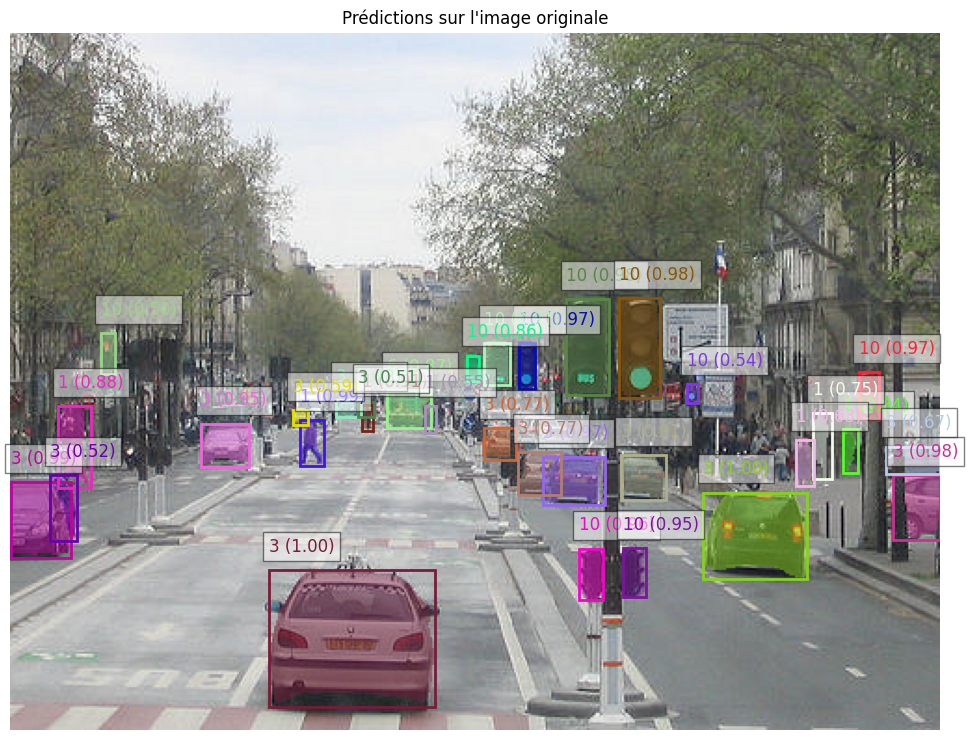

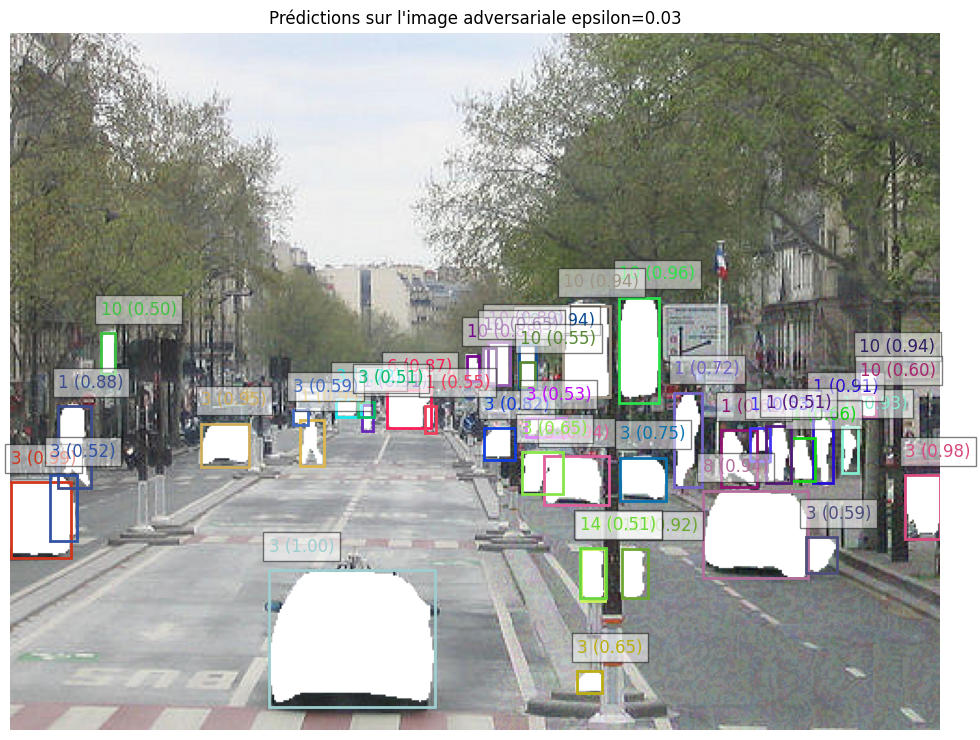

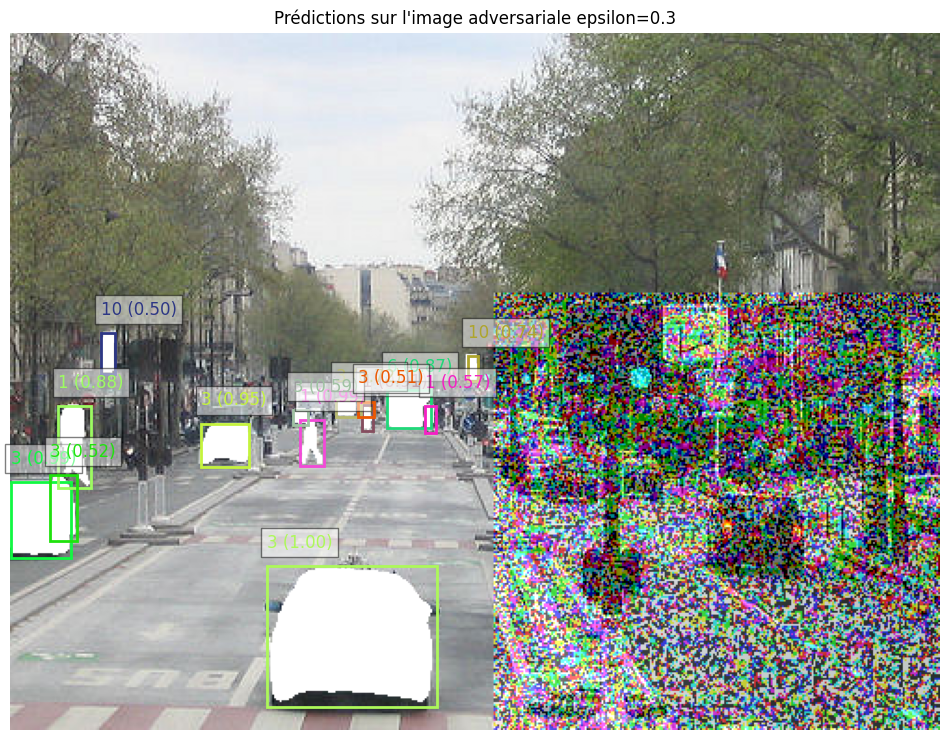

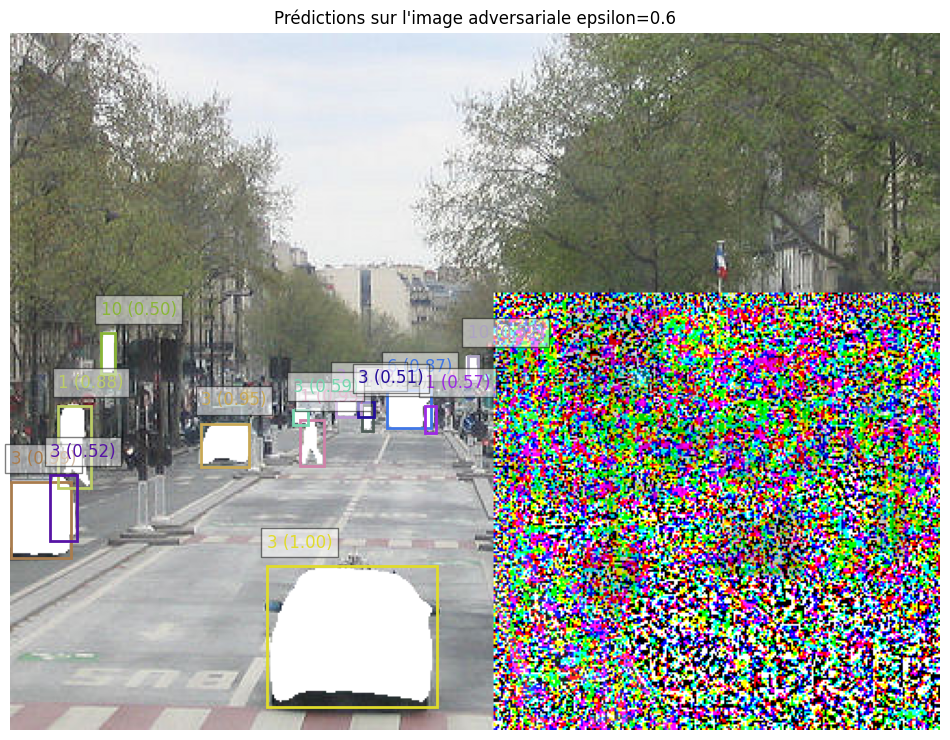

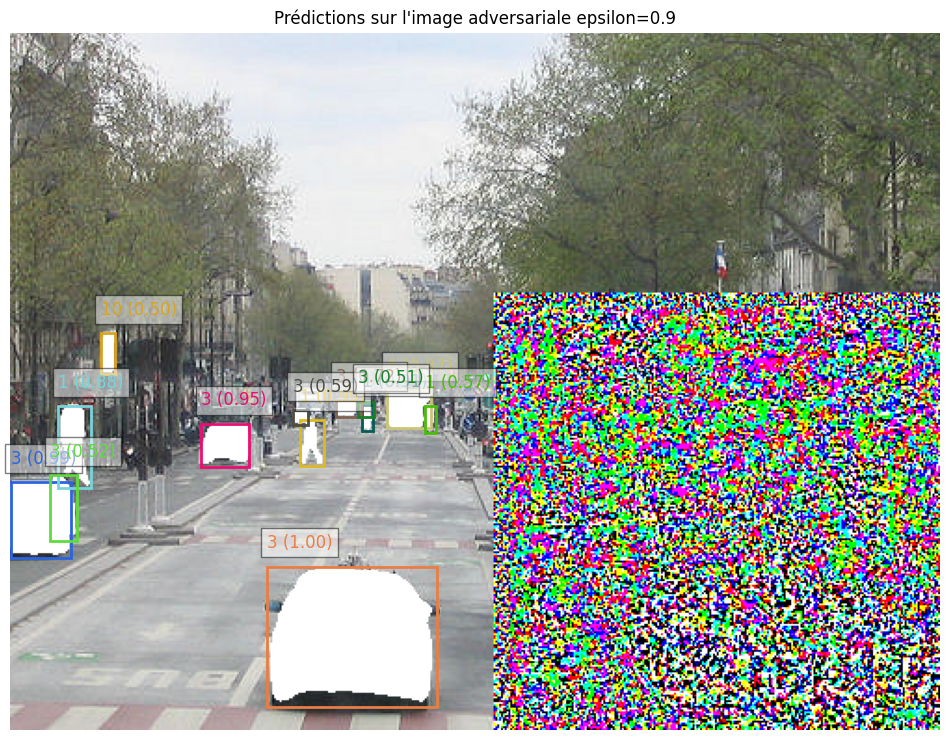

In [ ]:
# Charger l'image d'entrée
image_path = "12283150_12d37e6389_z.jpg"  # Remplacez par le chemin de votre image
image = Image.open(image_path).convert("RGB")

# Transformation de l'image
transform = T.Compose([T.ToTensor()])
input_tensor = transform(image).unsqueeze(0)  # Ajouter une dimension batch

#Appliquer l'attaque FGSM sur l'image d'entrée
adv_image1 = fgsm_attack(model, input_tensor, epsilon=0.03)
adv_image2 = fgsm_attack(model, input_tensor, epsilon=0.3)
adv_image3 = fgsm_attack(model, input_tensor, epsilon=0.6)
adv_image4 = fgsm_attack(model, input_tensor, epsilon=0.9)

# Passer l'image originale dans le modèle pour obtenir les prédictions
with torch.no_grad():
    output_original = model(input_tensor)[0]

# Afficher les détections sur l'image originale
display_predictions(np.array(image), output_original, threshold=0.5, title="Prédictions sur l'image originale")

# Passer l'image adversariale dans le modèle pour obtenir les prédictions
with torch.no_grad():
    output_adversarial1 = model(adv_image1)[0]
    output_adversarial2 = model(adv_image2)[0]
    output_adversarial3 = model(adv_image3)[0]
    output_adversarial4 = model(adv_image4)[0]

# Convertir l'image adversariale pour affichage
adversarial_image1 = adv_image1.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
adversarial_image2 = adv_image2.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
adversarial_image3 = adv_image3.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
adversarial_image4 = adv_image4.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

# Afficher les détections sur l'image adversariale
display_predictions(adversarial_image1, output_adversarial1, threshold=0.5, title="Prédictions sur l'image adversariale epsilon=0.03")
display_predictions(adversarial_image2, output_adversarial2, threshold=0.5, title="Prédictions sur l'image adversariale epsilon=0.3")
display_predictions(adversarial_image3, output_adversarial3, threshold=0.5, title="Prédictions sur l'image adversariale epsilon=0.6")
display_predictions(adversarial_image4, output_adversarial4, threshold=0.5, title="Prédictions sur l'image adversariale epsilon=0.9")